<span style="color:black;font-size:35px">**TODO - header**</span>

In [34]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as T
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm import tqdm
import sys
sys.path.append(r'..\models')
from vgg import VGG16
sys.path.pop()
sys.path.append(r'..\training')
from training import train_epoch
# from training import evaluate
sys.path.pop()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# FILEPATH = r"C:\Users\Evant\Documents\intel-image-classification"
FILEPATH = r"..\..\FISH0006 fishclassifierfinal\intel-image-classification"

In [35]:
def evaluate(model, test_data):
    model.eval()
    accuracy = 0
    with torch.no_grad():
        for (data, label) in test_data:
#             print(data)
            data = data.to(device)
#             label = torch.tensor(label)
#             print(label)
            label = label.to(device)
            out = model(data)
            answers = out.max(dim=1)[1]
#             answers = torch.max(out, dim=1)
#             print(answers)
            accuracy += (answers == label).sum()
    return accuracy

In [36]:
# not really useful at the moment
class My_Dataset(Dataset):
    def __init__(self, data_path, transform=None):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError
        
    def __getitem__(self, idx):
        raise NotImplementedError

In [37]:
class FishDataset(Dataset):
    def __init__(self, data_path, train=False, shuffle=False, transform=None):
        self.train = train
        self.transform = transform
        self.data_path = data_path
        datapoints = {}
        i = 0
        if train:
            for label in os.listdir(fr"{data_path}\seg_train\seg_train"):
                for image in os.listdir(fr"{data_path}\seg_train\seg_train\{label}"):
                    datapoints[image] = i
                i += 1
        else:
            for label in os.listdir(fr"{data_path}\seg_test\seg_test"):
                for image in os.listdir(fr"{data_path}\seg_test\seg_test\{label}"):
                    datapoints[image] = i
                i += 1
        self._num_labels = i
        if shuffle:
            k = list(datapoints.keys())
            random.shuffle(k)
            l = [(key, datapoints[key]) for key in k]
            datapoints = dict(l)
        self.labels = list(datapoints.values())
        self.images = list(datapoints.keys())
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        folders = os.listdir(fr"{self.data_path}\seg_train\seg_train")
        label = self.labels[idx]
        if self.train:
            img = Image.open(fr"{self.data_path}\seg_train\seg_train\{folders[label]}\{self.images[idx]}")
        else:
            img = Image.open(fr"{self.data_path}\seg_test\seg_test\{folders[label]}\{self.images[idx]}")
        # this data set contains a number of png files with an alpha channel
        img = img.convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
#         if not img.shape[0] == 3:
#             print(img.shape)
#             img = img.convert("RGB")
#             img.cv2.cvtColor(img, cv2.COLOR_BGRA)
        return img, label    

    def num_labels(self):
        return self._num_labels

In [38]:
fish_transform = T.Compose([T.Resize(size=(32,32)), 
                            T.RandomHorizontalFlip(), 
                            T.ToTensor(), 
                            T.Normalize(mean=[0.485, 0.456, 0.406], 
                                        std=[0.229, 0.224, 0.225])])

fish_train_set = FishDataset(FILEPATH, 
                             train=True, 
                             shuffle=True, 
                             transform=fish_transform)
fish_test_set = FishDataset(FILEPATH, 
                            train=False, 
                            shuffle=True, 
                            transform=fish_transform)

Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Image Shapes: torch.Size([3, 32, 32]), torch.Size([3, 32, 32])
Labels: tensor([24,  4])



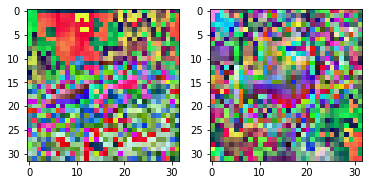

In [39]:
fish_investigation_dataset = DataLoader(fish_train_set, batch_size=2)
fish_data = iter(fish_investigation_dataset)
fish_single_point = next(fish_data)
print(f"""Type: {type(fish_single_point)}
Length: {len(fish_single_point)}
More Types: {type(fish_single_point[0])}, {type(fish_single_point[1])}
Image Shapes: {fish_single_point[0][0].shape}, {fish_single_point[0][1].shape}
Labels: {fish_single_point[1]}
""")

ToPIL = T.ToPILImage()
img0 = ToPIL(fish_single_point[0][0])
img1 = ToPIL(fish_single_point[0][1])
fi_1, axs_1 = plt.subplots(1,2)
axs_1[0].imshow(img0)
axs_1[1].imshow(img1)

<span style="color:black;font-size:35px">**Training**</span>

In [14]:
vgg_learning_rate = 1e-1
vgg_nepochs = 20
fish_batch_size = 64

fish_train_dataset = DataLoader(fish_train_set, batch_size=fish_batch_size)

vgg = VGG16(hidden_features=512, nout=30).to(device)

vgg_optimizer = optim.SGD(vgg.parameters(), lr=vgg_learning_rate)

loss_function = nn.CrossEntropyLoss()

vgg.train()
vgg_loss_history = []
for epoch in tqdm(range(vgg_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    vgg_loss_history.append(train_epoch(model=vgg, 
                                        train_data=fish_train_dataset, 
                                        LossFunction=loss_function, 
                                        optimizer=vgg_optimizer))
    print(f"Epoch {epoch}: loss: {vgg_loss_history[-1][-1]}")

Epoch:   5%|███▋                                                                     | 1/20 [00:15<04:56, 15.61s/epoch]

Epoch 0: loss: 2.102443218231201


Epoch:  10%|███████▎                                                                 | 2/20 [00:31<04:43, 15.78s/epoch]

Epoch 1: loss: 1.6331511735916138


Epoch:  15%|██████████▉                                                              | 3/20 [00:47<04:27, 15.75s/epoch]

Epoch 2: loss: 1.3002525568008423


Epoch:  20%|██████████████▌                                                          | 4/20 [01:02<04:10, 15.69s/epoch]

Epoch 3: loss: 1.2533286809921265


Epoch:  25%|██████████████████▎                                                      | 5/20 [01:18<03:54, 15.65s/epoch]

Epoch 4: loss: 0.6306467056274414


Epoch:  30%|█████████████████████▉                                                   | 6/20 [01:34<03:39, 15.70s/epoch]

Epoch 5: loss: 0.6514407396316528


Epoch:  35%|█████████████████████████▌                                               | 7/20 [01:49<03:23, 15.67s/epoch]

Epoch 6: loss: 0.6316776871681213


Epoch:  40%|█████████████████████████████▏                                           | 8/20 [02:05<03:07, 15.63s/epoch]

Epoch 7: loss: 0.3745250701904297


Epoch:  45%|████████████████████████████████▊                                        | 9/20 [02:20<02:51, 15.60s/epoch]

Epoch 8: loss: 0.2582033574581146


Epoch:  50%|████████████████████████████████████                                    | 10/20 [02:36<02:35, 15.57s/epoch]

Epoch 9: loss: 0.12340288609266281


Epoch:  55%|███████████████████████████████████████▌                                | 11/20 [02:51<02:20, 15.56s/epoch]

Epoch 10: loss: 0.16639477014541626


Epoch:  60%|███████████████████████████████████████████▏                            | 12/20 [03:07<02:04, 15.57s/epoch]

Epoch 11: loss: 0.20682722330093384


Epoch:  65%|██████████████████████████████████████████████▊                         | 13/20 [03:22<01:48, 15.54s/epoch]

Epoch 12: loss: 0.22152511775493622


Epoch:  70%|██████████████████████████████████████████████████▍                     | 14/20 [03:38<01:33, 15.53s/epoch]

Epoch 13: loss: 0.26112163066864014


Epoch:  75%|██████████████████████████████████████████████████████                  | 15/20 [03:53<01:17, 15.52s/epoch]

Epoch 14: loss: 0.1304589807987213


Epoch:  80%|█████████████████████████████████████████████████████████▌              | 16/20 [04:09<01:02, 15.53s/epoch]

Epoch 15: loss: 0.018367238342761993


Epoch:  85%|█████████████████████████████████████████████████████████████▏          | 17/20 [04:25<00:46, 15.54s/epoch]

Epoch 16: loss: 0.03290572389960289


Epoch:  90%|████████████████████████████████████████████████████████████████▊       | 18/20 [04:40<00:31, 15.54s/epoch]

Epoch 17: loss: 0.3687117099761963


Epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 19/20 [04:56<00:15, 15.54s/epoch]

Epoch 18: loss: 0.00987316109240055


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [05:11<00:00, 15.58s/epoch]

Epoch 19: loss: 0.12921443581581116


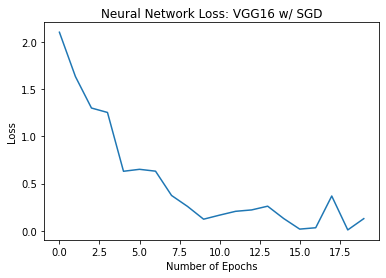

Total accuracy = 72.02%


In [15]:
fish_test_dataset = DataLoader(fish_test_set, batch_size=fish_batch_size)

plt.plot(list(map(lambda x: x[-1], vgg_loss_history)))
plt.title("Neural Network Loss: VGG16 w/ SGD")    
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.show()
vgg_accuracy = evaluate(vgg, fish_test_dataset)
print(f"Total accuracy = {vgg_accuracy / len(fish_test_set)*100:.2f}%")